# Train and test

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from interpret.glassbox import ExplainableBoostingClassifier
import geopandas as gpd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

## Data preprocessing

In [2]:
data=gpd.read_file('Data/SUs.shp')
filename = 'Variable_Selection/variable_selection.pkl'
results_auc= pickle.load(open(filename, 'rb'))

In [3]:
data['x']=data.geometry.centroid.x
data['y']=data.geometry.centroid.y
litho = ['Lit3', 'Lit5', 'Lit6', 'Lit10', 'Lit12', 'Lit16', 'Lit17']
data['litho'] = data[litho].idxmax(axis=1)
data['litho']=data.litho.astype('category')
lcover=['LC1','LC2', 'LC3', 'LC4', 'LC5', 'LC7']
data['lcover']=data[lcover].idxmax(axis=1)
data['lcover']=data.lcover.astype('category')
data['Catchment']=data.Catchment.astype('category')
soil=['Soil1', 'Soil2','Soil3', 'Soil4', 'Soil5', 'Soil6', 'Soil7', 'Soil8']
data['soil'] = data[soil].idxmax(axis=1)
data['soil']=data.soil.astype('category')

In [4]:
subs=results_auc[5]
sel_var=subs['Selected Features']
print(sel_var)

['Delta_mean', 'rain30day', 'Catchment', 'AreaSU', 'Slope_std', 'soil', 'lcover', 'litho', 'CS_mean', 'CA_mean']


In [5]:
data['Landslide'] = data['Landslide'].replace(np.nan, 0)
y=data.Landslide

In [6]:
unique,counts=np.unique(y, return_counts=True)
n_classes=2
w_0=len(y)/(n_classes*counts[0])
w_1=len(y)/(n_classes*counts[1])

## Model fit

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data[sel_var], y, test_size=0.30,random_state=42)
sample_weights = np.empty(len(y_train))
sample_weights[y_train == 0] = w_0
sample_weights[y_train == 1] = w_1
ebm_g=ExplainableBoostingClassifier(n_jobs=-1,outer_bags=30, min_samples_leaf=2,
                                     validation_size=0.2,interactions=[(0,1)], exclude=[1])
ebm_g.fit(X_train, y_train,sample_weight=sample_weights)

ExplainableBoostingClassifier(exclude=[1], interactions=[(0, 1)], n_jobs=-1,
                              outer_bags=30, validation_size=0.2)

In [8]:
filename = 'Outputs/modelSU.pkl'
pickle.dump(ebm_g, open(filename, 'wb'))

### Interactive model interpretation

In [9]:
from interpret import show
show(ebm_g.explain_global())

<!-- http://127.0.0.1:7001/2486503219008/ -->

## Test model

In [10]:
ebm_g.term_names_

['Delta_mean',
 'Catchment',
 'AreaSU',
 'Slope_std',
 'soil',
 'lcover',
 'litho',
 'CS_mean',
 'CA_mean',
 'Delta_mean & rain30day']

In [11]:
# put indices of covariates whose effects should be zeroed
ebm_g.term_scores_[1] = np.zeros_like(ebm_g.term_scores_[1])
ebm_g.term_scores_[2] = np.zeros_like(ebm_g.term_scores_[2])
y_predg=ebm_g.predict_proba(X_test[sel_var])[:, 1]
roc_auc_score(y_test,y_predg)

0.8726869158878505

## Plot reference model

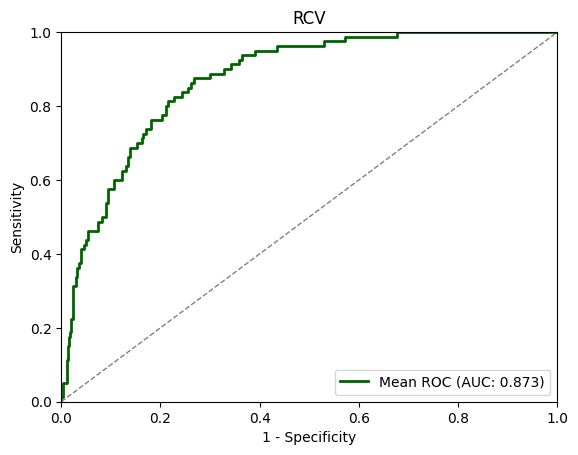

In [12]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test,y_predg)
auc = sklearn.metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'Mean ROC (AUC: {auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("RCV")
plt.legend(loc="lower right")
plt.savefig('Outputs/plots/rocs_reference.png',dpi=300)
plt.show()


## Prediction on the whole dataset

In [14]:
y_predf=ebm_g.predict_proba(data[sel_var])[:, 1]
roc_auc_score(y,y_predf)

0.8884675279099862

## Export data

In [15]:
file_model = 'Outputs/modelSU.pkl'
ebm= pickle.load(open(file_model, 'rb'))

In [16]:
ebm.term_scores_[1] = np.zeros_like(ebm.term_scores_[1])
ebm.term_scores_[2] = np.zeros_like(ebm.term_scores_[2])

C:\Users\Francesco Caleca\anaconda3\envs\Francesco\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



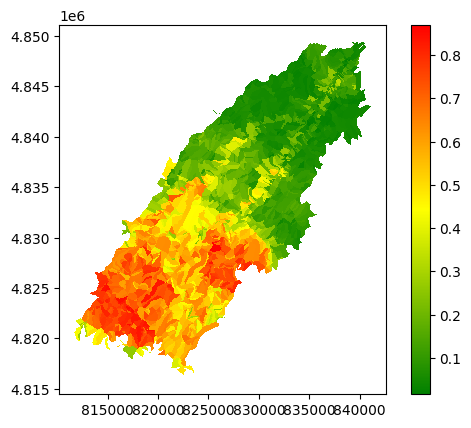

In [17]:
extr=['geometry','IDsu', 'AreaSU','Landslide']
susc=data[extr]
susc['susc']=y_predf
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('name', ['green', 'yellow', 'red'])
susc.plot(column='susc', legend=True,cmap=cmap)
plt.show()

## What if?

In [18]:
# for avoiding compunding effects related to the pairwise interaction we set its effect equal to zero
ebm_if=ebm
ebm_if.term_scores_[9] = np.zeros_like(ebm_if.term_scores_[9])

In [19]:
data2=data
data2['Delta_mean']=0.08
y_predf2=ebm_if.predict_proba(data2[sel_var])[:, 1]
#roc_auc_score(y,y_predf2)

In [20]:
data3=data
data3['Delta_mean']=0.18
y_predf3=ebm_if.predict_proba(data3[sel_var])[:, 1]
#roc_auc_score(y,y_predf3)

In [22]:
extr=['geometry','IDsu', 'AreaSU','Landslide']
susc=data2[extr]
susc['susc']=y_predf #starting susceptibility
susc['susc_dl']=y_predf2 #susc_dl stands for susceptibility with delta_mean low
susc['susc_dh']=y_predf3 #susc_dl stands for susceptibility with delta_mean high
susc['res_dl']=susc.susc_dl-susc.susc
susc['res_dh']=susc.susc_dh-susc.susc
susc.to_file('Outputs/susceptibility.shp')


C:\Users\Francesco Caleca\anaconda3\envs\Francesco\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Francesco Caleca\anaconda3\envs\Francesco\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Francesco Caleca\anaconda3\envs\Francesco\lib\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index